In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


In [ ]:
!pip install -q tensorflow-text

     |████████████████████████████████| 5.8 MB 10.3 MB/s 
     |████████████████████████████████| 588.3 MB 20 kB/s 
     |████████████████████████████████| 1.7 MB 53.0 MB/s 
     |████████████████████████████████| 439 kB 73.6 MB/s 
     |████████████████████████████████| 6.0 MB 52.5 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_clean=pd.read_csv('/content/drive/MyDrive/katia/clean_data.csv', sep='\t')
df_clean

,Unnamed: 0,title,text,subject,date,label
0,14137,german police detain suspect global online dru...,berlin reuters german police detained 29yearol...,worldnews,2017-11-22,0
1,6860,audit obamas irs misled american get sign obam...,soooo irs lied american prod comply sign obama...,Government News,2017-08-04,1
2,2204,republican total control state collapse,bobby jindal abandoned home state louisiana mo...,News,2016-03-04,1
3,19174,cant make black man win 16 million suing black...,word yet whether hispanic question referred pl...,politics,2015-09-13,1
4,1020,judge reject bid 18 state revive obamacare sub...,san franciscowashington reuters u judge wednes...,politicsNews,2017-10-25,0
...,...,...,...,...,...,...
44862,9741,high road martin luther king iii meet trump ti...,martin luther king iii met presidentelect dona...,politics,2017-01-16,1
44863,6424,watch gw bush gush kimmels antitrump oscar mon...,george w bush heaped praise jimmy kimmel antit...,left-news,2017-03-03,1
44864,840,failure leadership obama hillary fine leading ...,ad fantastic really nail failure leadership ob...,politics,2015-12-11,1
44865,12703,sri lanka parliament back tax exemption port d...,colombo reuters sri lanka parliament approved ...,worldnews,2017-12-08,0


In [ ]:
df_clean["label"].value_counts()

1    23450
0    21417
Name: label, dtype: int64

## Preprocessing

In [ ]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [ ]:
preprocess_url = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1')
encoder_url = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3')

In [ ]:
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

## Training model (title)

In [ ]:
#Split the dataset
#test_size=0.2, random_state=7, stratify=df_clean['label']
x_train,x_test,y_train,y_test=train_test_split(df_clean['title'], df_clean['label'],test_size=0.2, random_state=7 )

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='title')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 30 == 0:
        lr *= 0.2
        
    return max(lr, 3e-7)

In [ ]:
model_history = model.fit(
    x_train, y_train,
    epochs=50,
    steps_per_epoch=20,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=20, mode='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ])

Epoch 1/50
20/20 [==============================] - 37s 2s/step - loss: 0.6714 - accuracy: 0.5914 - precision: 0.6042 - recall: 0.6630 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 34s 2s/step - loss: 0.6319 - accuracy: 0.6633 - precision: 0.6719 - recall: 0.6554 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 36s 2s/step - loss: 0.6037 - accuracy: 0.7035 - precision: 0.7160 - recall: 0.7250 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 34s 2s/step - loss: 0.5656 - accuracy: 0.7492 - precision: 0.7503 - recall: 0.8104 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 35s 2s/step - loss: 0.5404 - accuracy: 0.7820 - precision: 0.7847 - recall: 0.7883 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - 34s 2s/step - loss: 0.5140 - accuracy: 0.7887 - precision: 0.7867 - recall: 0.8041 - lr: 0.0010
Epoch 7/50
20/20 [==============================] - 39s 2s/step - loss: 0.5092 - accuracy: 0.7812 - precision: 0

In [ ]:
model.save_weights("/content/drive/MyDrive/katia/model_title.h5")

In [ ]:
model_history.history

{'loss': [0.6714128255844116,
  0.6318638920783997,
  0.6037078499794006,
  0.5656453371047974,
  0.5403838157653809,
  0.5139812231063843,
  0.5092266798019409,
  0.49686503410339355,
  0.485635370016098,
  0.4678575396537781,
  0.45477503538131714,
  0.44485610723495483,
  0.437659353017807,
  0.43700289726257324,
  0.4394024908542633,
  0.4227539002895355,
  0.41780275106430054,
  0.4144773483276367,
  0.41276663541793823,
  0.40350890159606934,
  0.38674044609069824,
  0.40628689527511597,
  0.3731514513492584,
  0.3993867039680481,
  0.3936634659767151,
  0.3824302554130554,
  0.38904598355293274,
  0.38959962129592896,
  0.3803039491176605,
  0.3684002757072449,
  0.3747335970401764,
  0.386487752199173,
  0.3789525032043457,
  0.3653560280799866,
  0.3635370433330536,
  0.3610731065273285,
  0.3828059732913971,
  0.3740192651748657,
  0.376326322555542,
  0.36476045846939087,
  0.3806479573249817,
  0.36913222074508667,
  0.37371447682380676,
  0.3620184361934662,
  0.3810738921

In [ ]:
model.evaluate(x_test, y_test)

281/281 [==============================] - 97s 340ms/step - loss: 0.3515 - accuracy: 0.8579 - precision: 0.8658 - recall: 0.8646


[0.35148775577545166,
 0.8579229116439819,
 0.8658484816551208,
 0.8645679354667664]

In [ ]:
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

281/281 [==============================] - 95s 337ms/step


In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)

Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

#Build confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[3607,  634],
       [ 641, 4092]])

Text(33.0, 0.5, 'Truth')

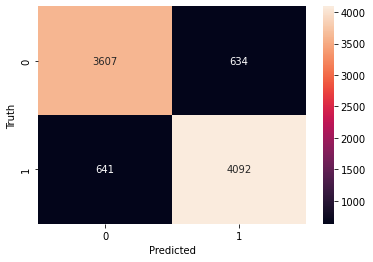

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4241
           1       0.87      0.86      0.87      4733

    accuracy                           0.86      8974
   macro avg       0.86      0.86      0.86      8974
weighted avg       0.86      0.86      0.86      8974



Example

In [ ]:
reviews = [
    "TRUMP ARRIVES IN MOBILE, ALABAMA TO SAY THANKS", 
    "Trump says Russia probe will be fair, but timeline unclear: NYT",
    "Virginia officials postpone lottery drawing to decide tied statehouse election",
    "Trump on Twitter (Dec 26) - Hillary Clinton, Tax Cut Bill"]
model.predict(reviews)

1/1 [==============================] - 1s 724ms/step


array([[0.5406584 ],
       [0.37870583],
       [0.01979244],
       [0.937006  ]], dtype=float32)